# Epoch = 20

Epoch 1: Loss = 36.0071, Train Acc = 0.5600, Dev Acc = 0.7010
Epoch 2: Loss = 20.0832, Train Acc = 0.8317, Dev Acc = 0.7108
Epoch 3: Loss = 10.6749, Train Acc = 0.9241, Dev Acc = 0.6863
Epoch 4: Loss = 4.9047, Train Acc = 0.9639, Dev Acc = 0.7353
Epoch 5: Loss = 3.1052, Train Acc = 0.9780, Dev Acc = 0.7206
Epoch 6: Loss = 2.4445, Train Acc = 0.9823, Dev Acc = 0.7157
Epoch 7: Loss = 1.3917, Train Acc = 0.9890, Dev Acc = 0.7181
Epoch 8: Loss = 1.0809, Train Acc = 0.9902, Dev Acc = 0.7206
Epoch 9: Loss = 1.0974, Train Acc = 0.9933, Dev Acc = 0.7328
Epoch 10: Loss = 1.4583, Train Acc = 0.9865, Dev Acc = 0.7157
Epoch 11: Loss = 1.1581, Train Acc = 0.9963, Dev Acc = 0.7157
Epoch 12: Loss = 5.3577, Train Acc = 0.9651, Dev Acc = 0.7181
Epoch 13: Loss = 1.6283, Train Acc = 0.9914, Dev Acc = 0.7132
Epoch 14: Loss = 2.6213, Train Acc = 0.9841, Dev Acc = 0.6765
Epoch 15: Loss = 1.5934, Train Acc = 0.9871, Dev Acc = 0.7304
Epoch 16: Loss = 1.0614, Train Acc = 0.9920, Dev Acc = 0.7304
Epoch 17: Loss

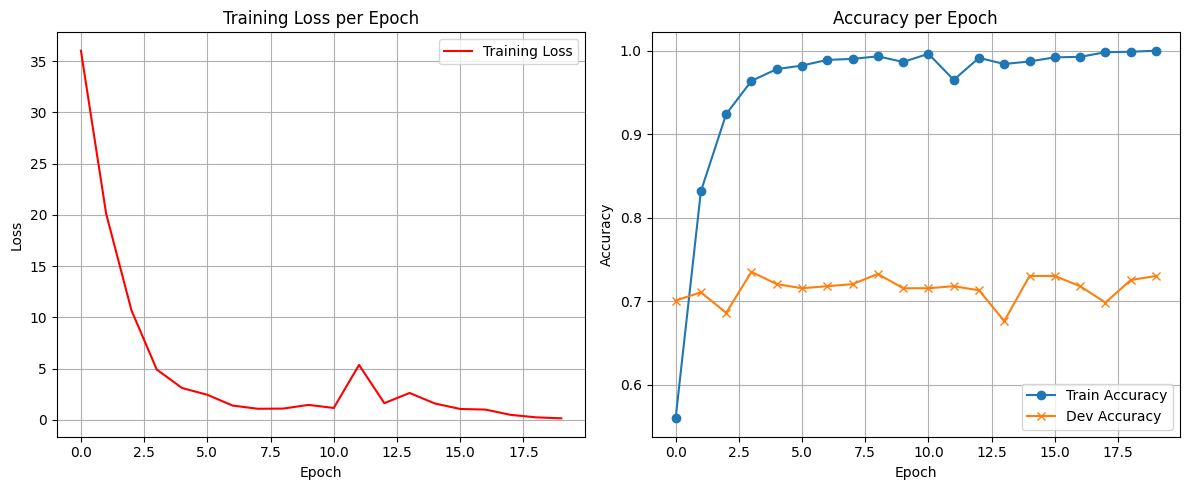


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7098    0.7794    0.7430       204
           1     0.7554    0.6814    0.7165       204

    accuracy                         0.7304       408
   macro avg     0.7326    0.7304    0.7297       408
weighted avg     0.7326    0.7304    0.7297       408

Confusion Matrix:
 [[159  45]
 [ 65 139]]


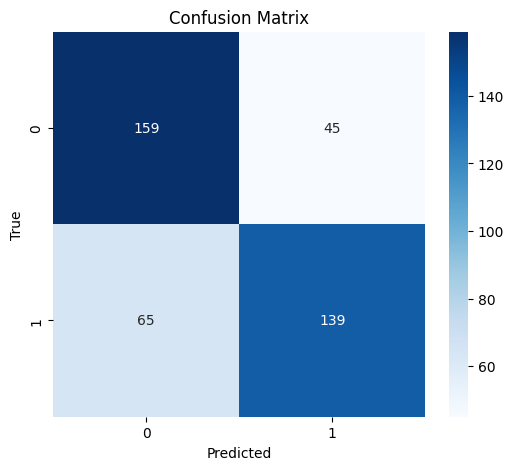


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6840    0.8123    0.7426       341
           1     0.7690    0.6246    0.6893       341

    accuracy                         0.7185       682
   macro avg     0.7265    0.7185    0.7160       682
weighted avg     0.7265    0.7185    0.7160       682

Confusion Matrix:
 [[277  64]
 [128 213]]


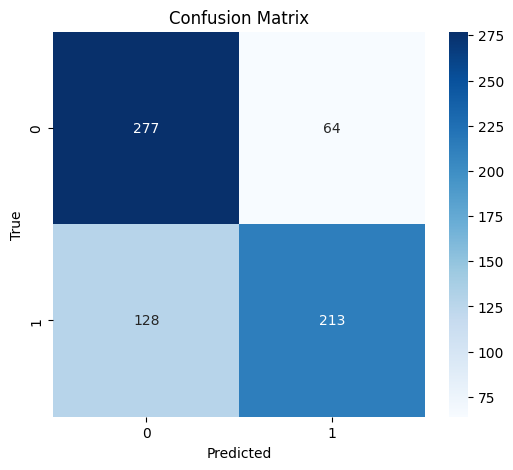

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Epoch = 10

Epoch 1: Loss = 36.5668, Train Acc = 0.5612, Dev Acc = 0.6495
Epoch 2: Loss = 19.3037, Train Acc = 0.8360, Dev Acc = 0.6863
Epoch 3: Loss = 11.9673, Train Acc = 0.9168, Dev Acc = 0.6912
Epoch 4: Loss = 8.6605, Train Acc = 0.9382, Dev Acc = 0.6740
Epoch 5: Loss = 6.9057, Train Acc = 0.9517, Dev Acc = 0.7181
Epoch 6: Loss = 3.8648, Train Acc = 0.9712, Dev Acc = 0.7451
Epoch 7: Loss = 1.8585, Train Acc = 0.9884, Dev Acc = 0.7230
Epoch 8: Loss = 1.4139, Train Acc = 0.9890, Dev Acc = 0.7304
Epoch 9: Loss = 0.9967, Train Acc = 0.9927, Dev Acc = 0.7132
Epoch 10: Loss = 1.9879, Train Acc = 0.9884, Dev Acc = 0.7255


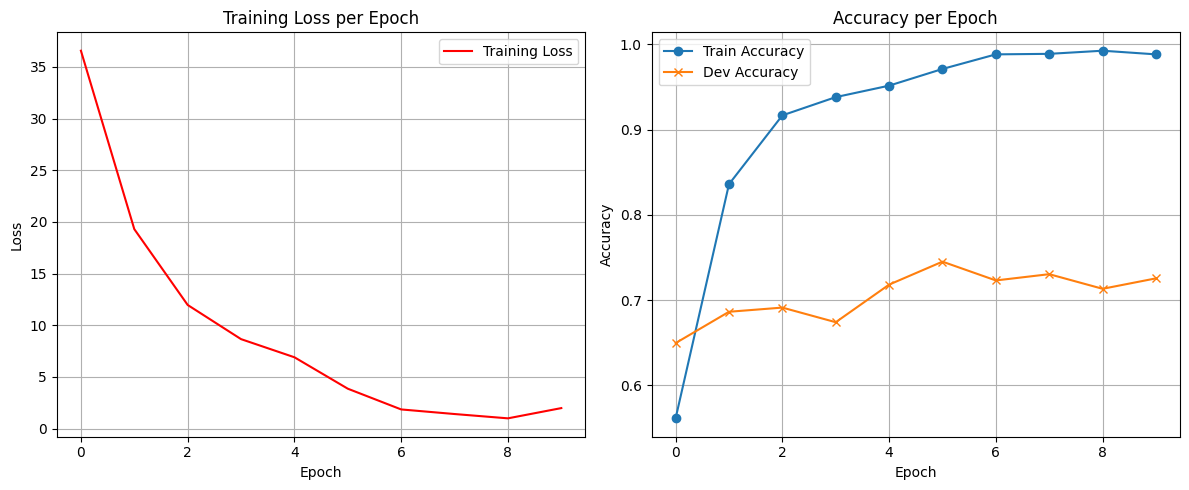


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7233    0.7304    0.7268       204
           1     0.7277    0.7206    0.7241       204

    accuracy                         0.7255       408
   macro avg     0.7255    0.7255    0.7255       408
weighted avg     0.7255    0.7255    0.7255       408

Confusion Matrix:
 [[149  55]
 [ 57 147]]


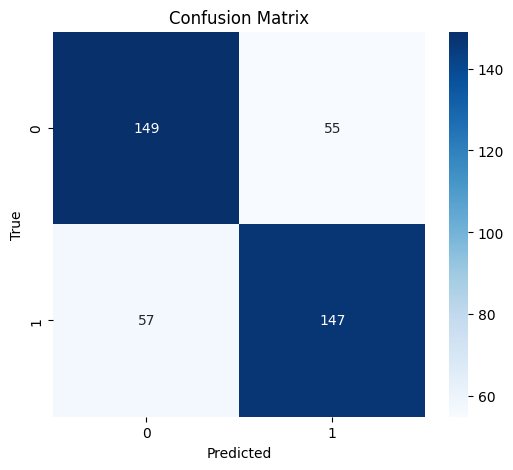


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6782    0.7478    0.7113       341
           1     0.7190    0.6452    0.6801       341

    accuracy                         0.6965       682
   macro avg     0.6986    0.6965    0.6957       682
weighted avg     0.6986    0.6965    0.6957       682

Confusion Matrix:
 [[255  86]
 [121 220]]


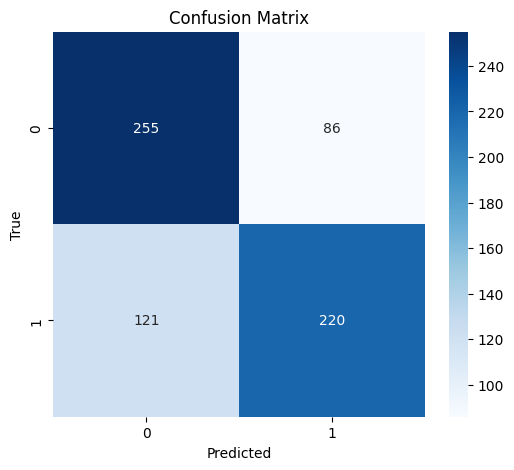

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 10
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Epoch = 30

Epoch 1: Loss = 36.9335, Train Acc = 0.5747, Dev Acc = 0.7059
Epoch 2: Loss = 21.6020, Train Acc = 0.8244, Dev Acc = 0.6422
Epoch 3: Loss = 13.3481, Train Acc = 0.9076, Dev Acc = 0.7034
Epoch 4: Loss = 7.9773, Train Acc = 0.9449, Dev Acc = 0.7328
Epoch 5: Loss = 5.6807, Train Acc = 0.9584, Dev Acc = 0.7132
Epoch 6: Loss = 3.2544, Train Acc = 0.9743, Dev Acc = 0.7034
Epoch 7: Loss = 3.3413, Train Acc = 0.9798, Dev Acc = 0.7206
Epoch 8: Loss = 2.3160, Train Acc = 0.9853, Dev Acc = 0.7377
Epoch 9: Loss = 1.0881, Train Acc = 0.9920, Dev Acc = 0.7451
Epoch 10: Loss = 0.3134, Train Acc = 0.9988, Dev Acc = 0.7451
Epoch 11: Loss = 0.3722, Train Acc = 0.9976, Dev Acc = 0.7672
Epoch 12: Loss = 1.1439, Train Acc = 0.9914, Dev Acc = 0.7230
Epoch 13: Loss = 0.5838, Train Acc = 0.9963, Dev Acc = 0.7549
Epoch 14: Loss = 0.4764, Train Acc = 0.9963, Dev Acc = 0.7647
Epoch 15: Loss = 0.6101, Train Acc = 0.9957, Dev Acc = 0.7377
Epoch 16: Loss = 0.3021, Train Acc = 0.9982, Dev Acc = 0.7402
Epoch 17: Loss

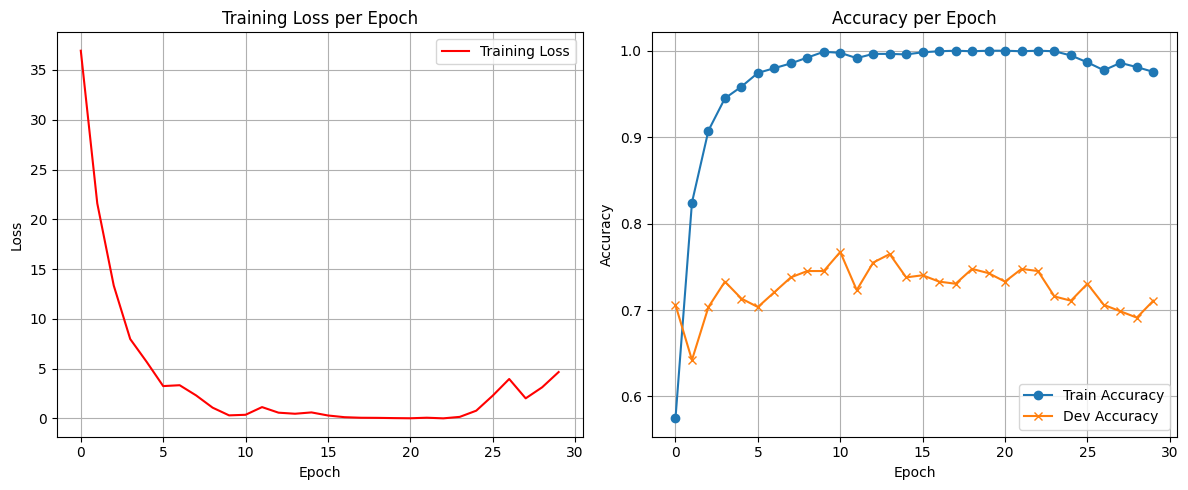


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7792    0.5882    0.6704       204
           1     0.6693    0.8333    0.7424       204

    accuracy                         0.7108       408
   macro avg     0.7243    0.7108    0.7064       408
weighted avg     0.7243    0.7108    0.7064       408

Confusion Matrix:
 [[120  84]
 [ 34 170]]


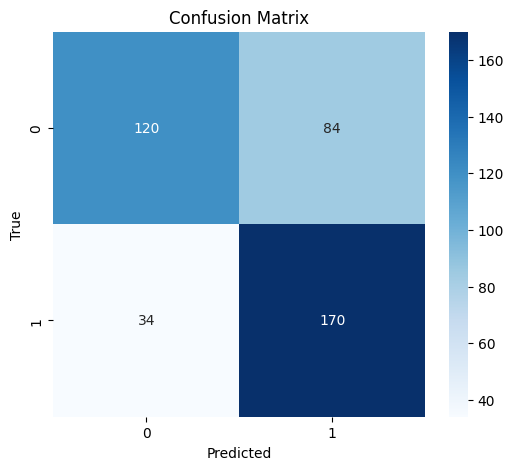


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7138    0.6217    0.6646       341
           1     0.6649    0.7507    0.7052       341

    accuracy                         0.6862       682
   macro avg     0.6894    0.6862    0.6849       682
weighted avg     0.6894    0.6862    0.6849       682

Confusion Matrix:
 [[212 129]
 [ 85 256]]


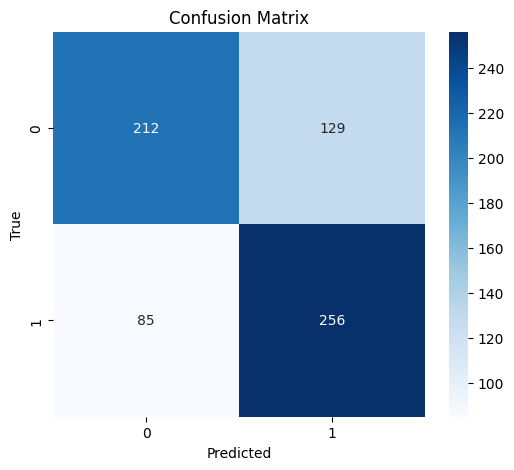

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 30
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Opt = Adam

Epoch 1: Loss = 39.4009, Train Acc = 0.5165, Dev Acc = 0.6397
Epoch 2: Loss = 24.5951, Train Acc = 0.7846, Dev Acc = 0.6863
Epoch 3: Loss = 14.5244, Train Acc = 0.9015, Dev Acc = 0.6740
Epoch 4: Loss = 9.2618, Train Acc = 0.9382, Dev Acc = 0.7157
Epoch 5: Loss = 6.0618, Train Acc = 0.9596, Dev Acc = 0.6985
Epoch 6: Loss = 3.7207, Train Acc = 0.9755, Dev Acc = 0.6985
Epoch 7: Loss = 2.4389, Train Acc = 0.9829, Dev Acc = 0.7279
Epoch 8: Loss = 2.6213, Train Acc = 0.9829, Dev Acc = 0.7230
Epoch 9: Loss = 2.7472, Train Acc = 0.9786, Dev Acc = 0.7108
Epoch 10: Loss = 0.8837, Train Acc = 0.9927, Dev Acc = 0.6912
Epoch 11: Loss = 2.4254, Train Acc = 0.9829, Dev Acc = 0.7181
Epoch 12: Loss = 1.6364, Train Acc = 0.9890, Dev Acc = 0.7255
Epoch 13: Loss = 1.4337, Train Acc = 0.9914, Dev Acc = 0.7157
Epoch 14: Loss = 0.5488, Train Acc = 0.9976, Dev Acc = 0.7451
Epoch 15: Loss = 0.3376, Train Acc = 0.9969, Dev Acc = 0.7353
Epoch 16: Loss = 0.3670, Train Acc = 0.9963, Dev Acc = 0.7181
Epoch 17: Loss

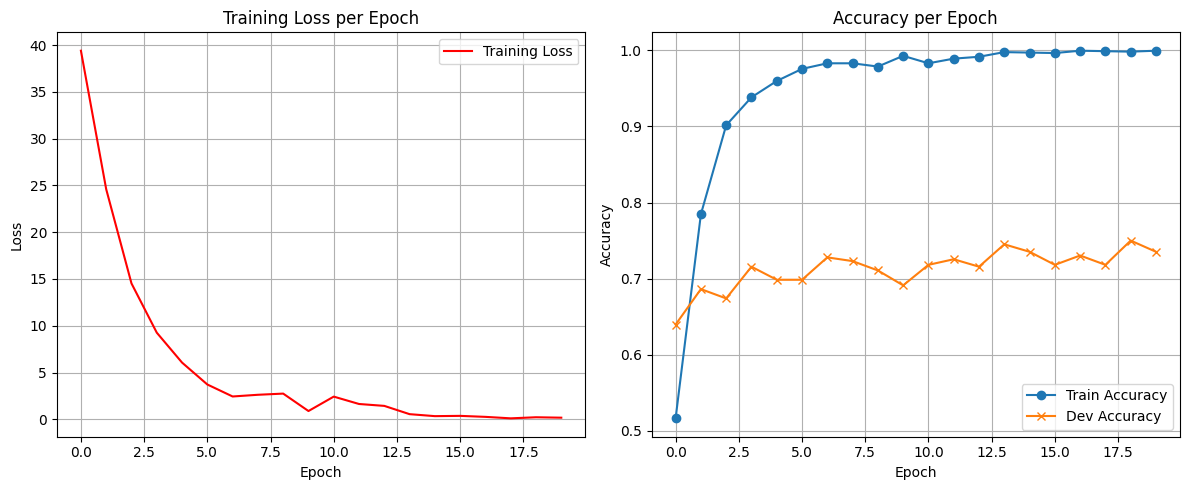


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7182    0.7745    0.7453       204
           1     0.7553    0.6961    0.7245       204

    accuracy                         0.7353       408
   macro avg     0.7368    0.7353    0.7349       408
weighted avg     0.7368    0.7353    0.7349       408

Confusion Matrix:
 [[158  46]
 [ 62 142]]


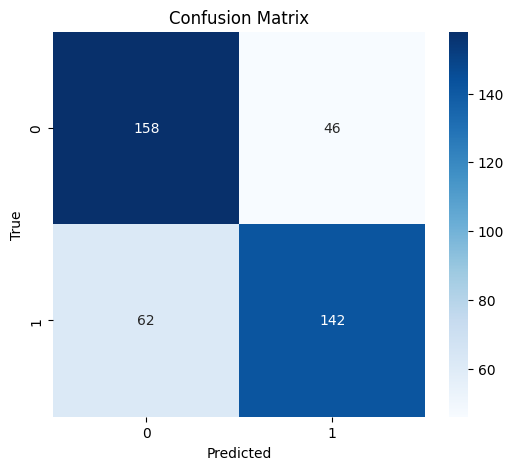


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6691    0.8123    0.7338       341
           1     0.7612    0.5982    0.6700       341

    accuracy                         0.7053       682
   macro avg     0.7151    0.7053    0.7019       682
weighted avg     0.7151    0.7053    0.7019       682

Confusion Matrix:
 [[277  64]
 [137 204]]


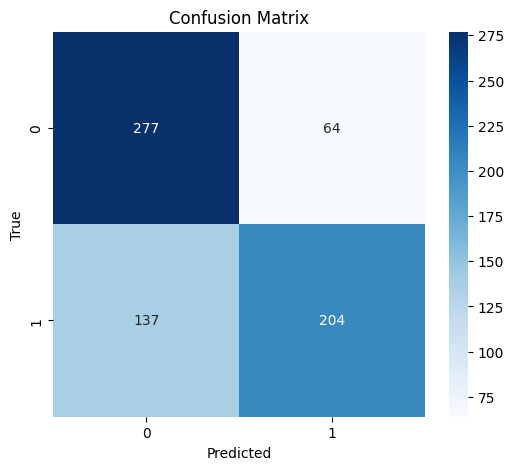

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Opt = SGD

Epoch 1: Loss = 36.6440, Train Acc = 0.5067, Dev Acc = 0.5270
Epoch 2: Loss = 36.0910, Train Acc = 0.5220, Dev Acc = 0.5172
Epoch 3: Loss = 35.8223, Train Acc = 0.5410, Dev Acc = 0.5294
Epoch 4: Loss = 35.8290, Train Acc = 0.5379, Dev Acc = 0.5392
Epoch 5: Loss = 35.1538, Train Acc = 0.5747, Dev Acc = 0.5858
Epoch 6: Loss = 35.0551, Train Acc = 0.5685, Dev Acc = 0.5760
Epoch 7: Loss = 34.7654, Train Acc = 0.5918, Dev Acc = 0.6348
Epoch 8: Loss = 34.5625, Train Acc = 0.5973, Dev Acc = 0.6324
Epoch 9: Loss = 33.9815, Train Acc = 0.6144, Dev Acc = 0.6446
Epoch 10: Loss = 33.5780, Train Acc = 0.6279, Dev Acc = 0.6520
Epoch 11: Loss = 33.9818, Train Acc = 0.6310, Dev Acc = 0.5490
Epoch 12: Loss = 32.9519, Train Acc = 0.6359, Dev Acc = 0.6397
Epoch 13: Loss = 32.3602, Train Acc = 0.6616, Dev Acc = 0.6446
Epoch 14: Loss = 31.9297, Train Acc = 0.6695, Dev Acc = 0.6765
Epoch 15: Loss = 31.7319, Train Acc = 0.6640, Dev Acc = 0.6912
Epoch 16: Loss = 30.7938, Train Acc = 0.6824, Dev Acc = 0.6520
E

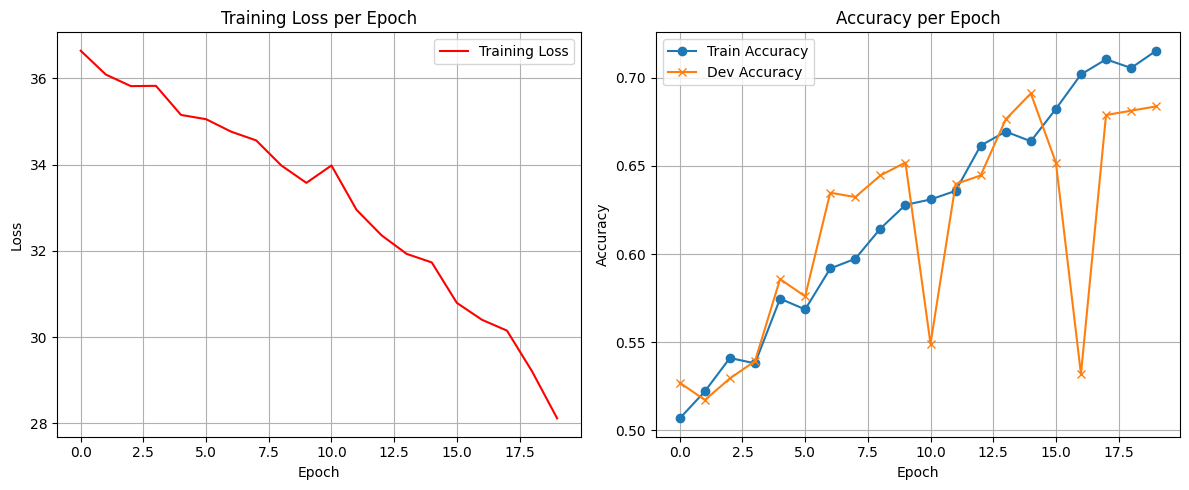


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.6374    0.8529    0.7296       204
           1     0.7778    0.5147    0.6195       204

    accuracy                         0.6838       408
   macro avg     0.7076    0.6838    0.6745       408
weighted avg     0.7076    0.6838    0.6745       408

Confusion Matrix:
 [[174  30]
 [ 99 105]]


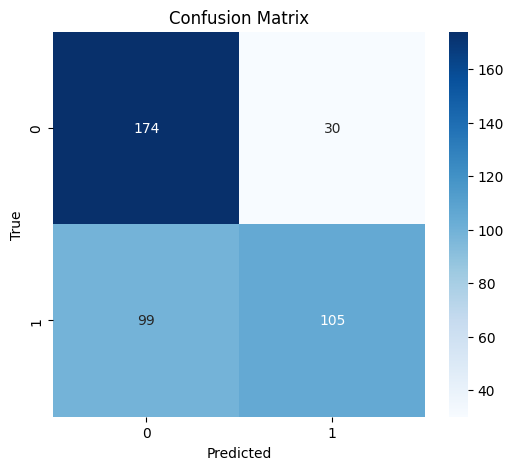


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6503    0.8563    0.7392       341
           1     0.7897    0.5396    0.6411       341

    accuracy                         0.6979       682
   macro avg     0.7200    0.6979    0.6902       682
weighted avg     0.7200    0.6979    0.6902       682

Confusion Matrix:
 [[292  49]
 [157 184]]


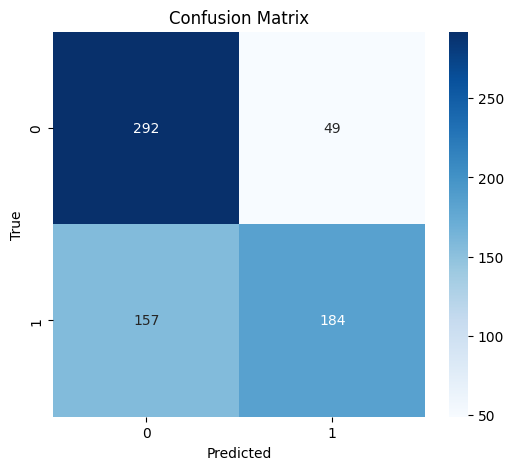

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "SGD"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# 100 D

Epoch 1: Loss = 35.5363, Train Acc = 0.5826, Dev Acc = 0.7181
Epoch 2: Loss = 20.4033, Train Acc = 0.8366, Dev Acc = 0.5221
Epoch 3: Loss = 16.1175, Train Acc = 0.8794, Dev Acc = 0.7010
Epoch 4: Loss = 7.8358, Train Acc = 0.9382, Dev Acc = 0.6936
Epoch 5: Loss = 4.0240, Train Acc = 0.9676, Dev Acc = 0.7157
Epoch 6: Loss = 2.5598, Train Acc = 0.9829, Dev Acc = 0.7426
Epoch 7: Loss = 3.3906, Train Acc = 0.9749, Dev Acc = 0.7598
Epoch 8: Loss = 2.9766, Train Acc = 0.9774, Dev Acc = 0.7647
Epoch 9: Loss = 0.9638, Train Acc = 0.9945, Dev Acc = 0.7500
Epoch 10: Loss = 0.7631, Train Acc = 0.9951, Dev Acc = 0.7647
Epoch 11: Loss = 0.7079, Train Acc = 0.9945, Dev Acc = 0.7574
Epoch 12: Loss = 0.6044, Train Acc = 0.9963, Dev Acc = 0.7402
Epoch 13: Loss = 0.5287, Train Acc = 0.9982, Dev Acc = 0.7377
Epoch 14: Loss = 0.4732, Train Acc = 0.9976, Dev Acc = 0.7525
Epoch 15: Loss = 0.1177, Train Acc = 1.0000, Dev Acc = 0.7377
Epoch 16: Loss = 0.0629, Train Acc = 1.0000, Dev Acc = 0.7328
Epoch 17: Loss

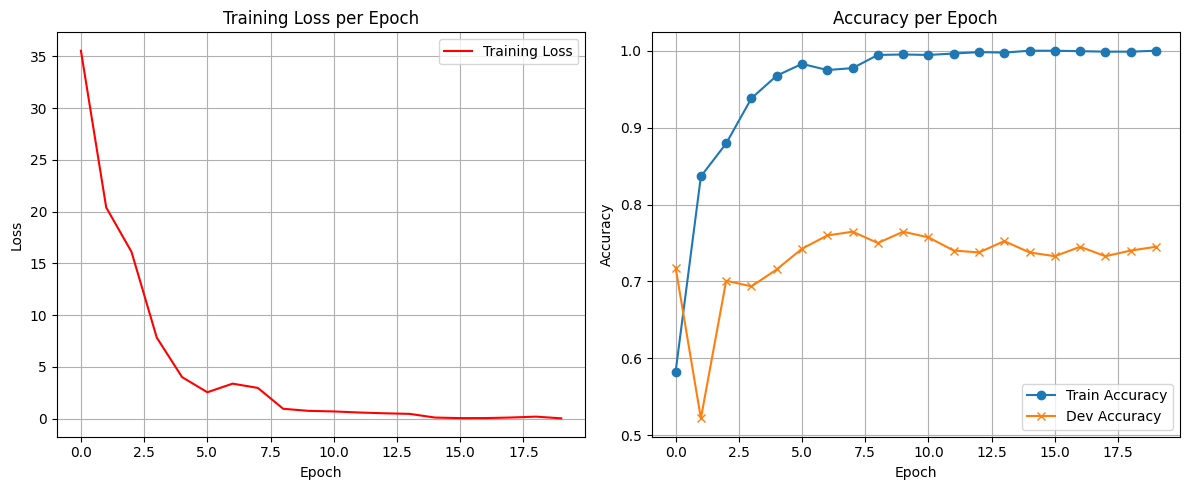


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7660    0.7059    0.7347       204
           1     0.7273    0.7843    0.7547       204

    accuracy                         0.7451       408
   macro avg     0.7466    0.7451    0.7447       408
weighted avg     0.7466    0.7451    0.7447       408

Confusion Matrix:
 [[144  60]
 [ 44 160]]


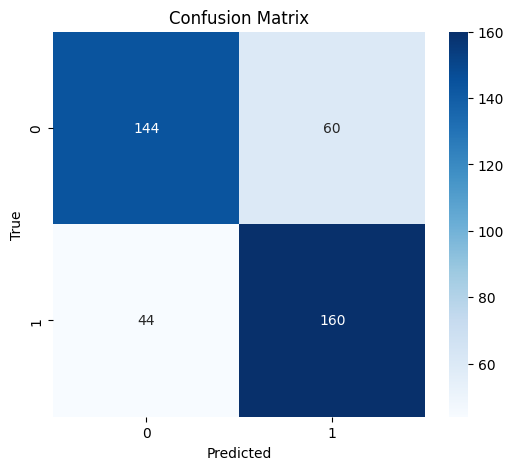


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7089    0.7214    0.7151       341
           1     0.7164    0.7038    0.7101       341

    accuracy                         0.7126       682
   macro avg     0.7127    0.7126    0.7126       682
weighted avg     0.7127    0.7126    0.7126       682

Confusion Matrix:
 [[246  95]
 [101 240]]


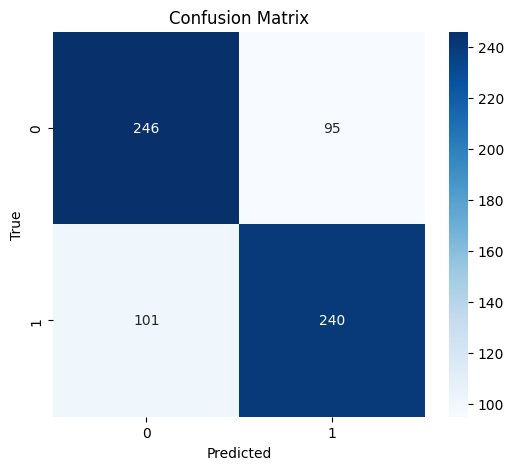

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# 300 D

Epoch 1: Loss = 35.4904, Train Acc = 0.5930, Dev Acc = 0.6887
Epoch 2: Loss = 15.3424, Train Acc = 0.8776, Dev Acc = 0.7255
Epoch 3: Loss = 6.5562, Train Acc = 0.9541, Dev Acc = 0.7549
Epoch 4: Loss = 5.9981, Train Acc = 0.9584, Dev Acc = 0.7623
Epoch 5: Loss = 2.9725, Train Acc = 0.9798, Dev Acc = 0.7525
Epoch 6: Loss = 1.4509, Train Acc = 0.9884, Dev Acc = 0.7574
Epoch 7: Loss = 1.9900, Train Acc = 0.9884, Dev Acc = 0.7549
Epoch 8: Loss = 1.5569, Train Acc = 0.9933, Dev Acc = 0.7672
Epoch 9: Loss = 1.4328, Train Acc = 0.9908, Dev Acc = 0.7500
Epoch 10: Loss = 0.7516, Train Acc = 0.9945, Dev Acc = 0.7304
Epoch 11: Loss = 0.5019, Train Acc = 0.9988, Dev Acc = 0.7475
Epoch 12: Loss = 0.2523, Train Acc = 0.9988, Dev Acc = 0.7377
Epoch 13: Loss = 0.8675, Train Acc = 0.9957, Dev Acc = 0.7255
Epoch 14: Loss = 1.8021, Train Acc = 0.9859, Dev Acc = 0.7132
Epoch 15: Loss = 2.0721, Train Acc = 0.9853, Dev Acc = 0.7377
Epoch 16: Loss = 2.2405, Train Acc = 0.9841, Dev Acc = 0.6544
Epoch 17: Loss 

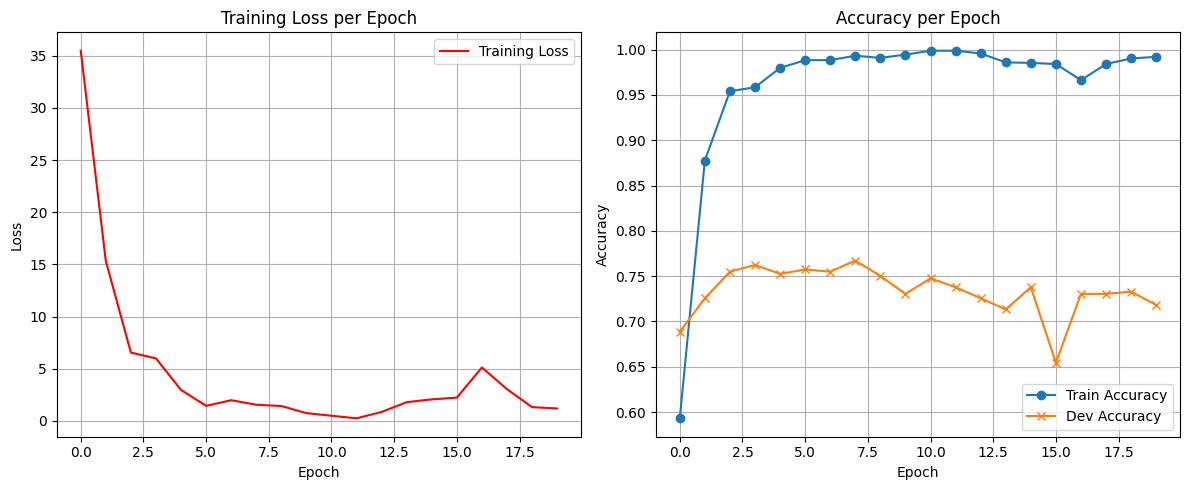


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7070    0.7451    0.7255       204
           1     0.7306    0.6912    0.7103       204

    accuracy                         0.7181       408
   macro avg     0.7188    0.7181    0.7179       408
weighted avg     0.7188    0.7181    0.7179       408

Confusion Matrix:
 [[152  52]
 [ 63 141]]


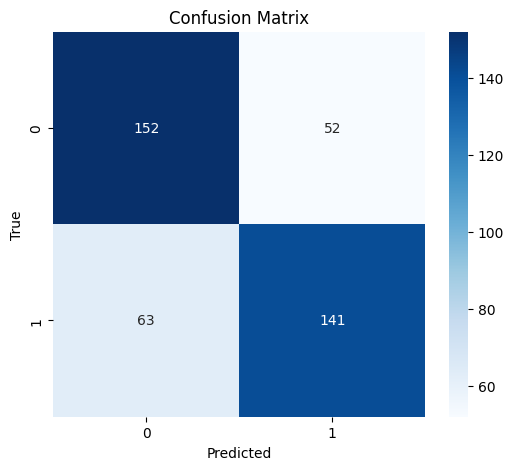


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7003    0.7331    0.7163       341
           1     0.7200    0.6862    0.7027       341

    accuracy                         0.7097       682
   macro avg     0.7101    0.7097    0.7095       682
weighted avg     0.7101    0.7097    0.7095       682

Confusion Matrix:
 [[250  91]
 [107 234]]


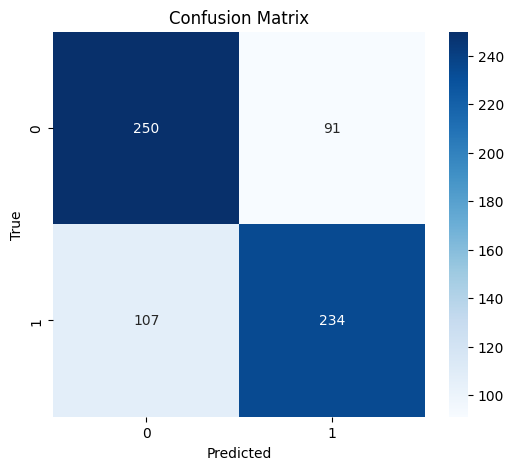

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# LR = 1e-3


Epoch 1: Loss = 34.9120, Train Acc = 0.5765, Dev Acc = 0.6691
Epoch 2: Loss = 27.1086, Train Acc = 0.7436, Dev Acc = 0.7255
Epoch 3: Loss = 20.6176, Train Acc = 0.8213, Dev Acc = 0.7868
Epoch 4: Loss = 12.1545, Train Acc = 0.9027, Dev Acc = 0.7843
Epoch 5: Loss = 6.0535, Train Acc = 0.9627, Dev Acc = 0.7917
Epoch 6: Loss = 3.3558, Train Acc = 0.9780, Dev Acc = 0.7990
Epoch 7: Loss = 1.3881, Train Acc = 0.9927, Dev Acc = 0.7770
Epoch 8: Loss = 1.3080, Train Acc = 0.9920, Dev Acc = 0.7279
Epoch 9: Loss = 0.4641, Train Acc = 0.9969, Dev Acc = 0.7525
Epoch 10: Loss = 0.2126, Train Acc = 0.9988, Dev Acc = 0.7696
Epoch 11: Loss = 0.0776, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 12: Loss = 0.0724, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 13: Loss = 0.0437, Train Acc = 1.0000, Dev Acc = 0.7598
Epoch 14: Loss = 0.0318, Train Acc = 1.0000, Dev Acc = 0.7574
Epoch 15: Loss = 0.0280, Train Acc = 1.0000, Dev Acc = 0.7574
Epoch 16: Loss = 0.0280, Train Acc = 1.0000, Dev Acc = 0.7574
Epoch 17: Los

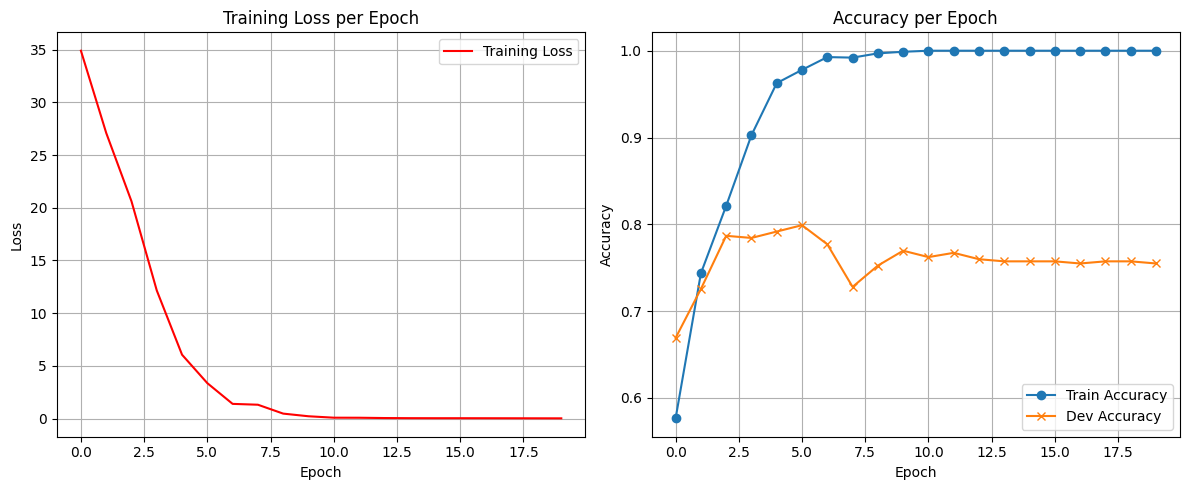


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8421    0.6275    0.7191       204
           1     0.7031    0.8824    0.7826       204

    accuracy                         0.7549       408
   macro avg     0.7726    0.7549    0.7509       408
weighted avg     0.7726    0.7549    0.7509       408

Confusion Matrix:
 [[128  76]
 [ 24 180]]


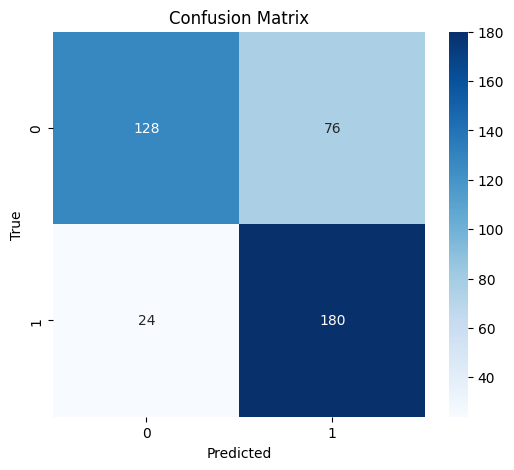


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8175    0.6305    0.7119       341
           1     0.6993    0.8592    0.7711       341

    accuracy                         0.7449       682
   macro avg     0.7584    0.7449    0.7415       682
weighted avg     0.7584    0.7449    0.7415       682

Confusion Matrix:
 [[215 126]
 [ 48 293]]


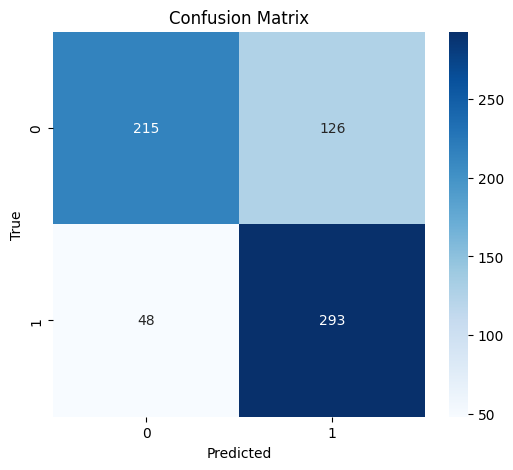

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 1e-3
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# LR = 5e-4

Epoch 1: Loss = 35.3116, Train Acc = 0.5655, Dev Acc = 0.5907
Epoch 2: Loss = 30.9632, Train Acc = 0.6799, Dev Acc = 0.7010
Epoch 3: Loss = 25.4371, Train Acc = 0.7729, Dev Acc = 0.7598
Epoch 4: Loss = 21.6256, Train Acc = 0.8121, Dev Acc = 0.7672
Epoch 5: Loss = 17.3957, Train Acc = 0.8629, Dev Acc = 0.7623
Epoch 6: Loss = 12.4110, Train Acc = 0.9088, Dev Acc = 0.7672
Epoch 7: Loss = 8.3553, Train Acc = 0.9480, Dev Acc = 0.7500
Epoch 8: Loss = 5.9227, Train Acc = 0.9645, Dev Acc = 0.7475
Epoch 9: Loss = 3.7211, Train Acc = 0.9774, Dev Acc = 0.7647
Epoch 10: Loss = 2.5977, Train Acc = 0.9823, Dev Acc = 0.7500
Epoch 11: Loss = 2.4194, Train Acc = 0.9865, Dev Acc = 0.7500
Epoch 12: Loss = 2.8969, Train Acc = 0.9755, Dev Acc = 0.7745
Epoch 13: Loss = 0.6229, Train Acc = 0.9969, Dev Acc = 0.7574
Epoch 14: Loss = 0.3131, Train Acc = 1.0000, Dev Acc = 0.7574
Epoch 15: Loss = 0.2527, Train Acc = 1.0000, Dev Acc = 0.7598
Epoch 16: Loss = 0.2268, Train Acc = 1.0000, Dev Acc = 0.7549
Epoch 17: L

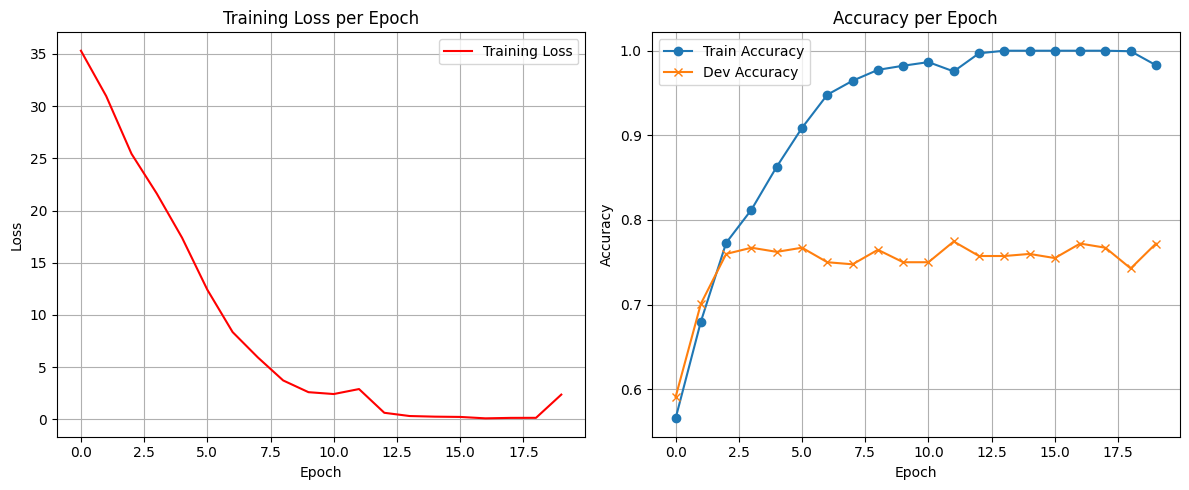


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8101    0.7108    0.7572       204
           1     0.7424    0.8333    0.7852       204

    accuracy                         0.7721       408
   macro avg     0.7762    0.7721    0.7712       408
weighted avg     0.7762    0.7721    0.7712       408

Confusion Matrix:
 [[145  59]
 [ 34 170]]


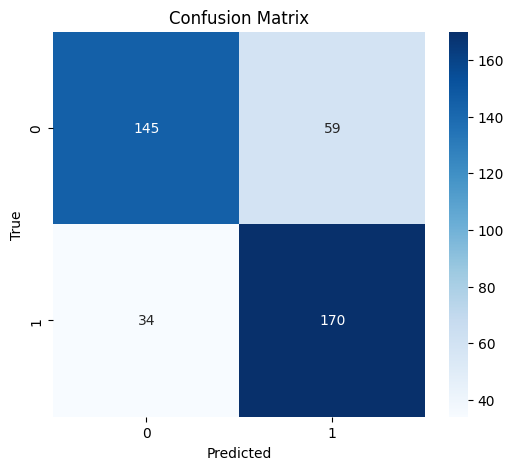


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7382    0.6862    0.7112       341
           1     0.7068    0.7566    0.7309       341

    accuracy                         0.7214       682
   macro avg     0.7225    0.7214    0.7211       682
weighted avg     0.7225    0.7214    0.7211       682

Confusion Matrix:
 [[234 107]
 [ 83 258]]


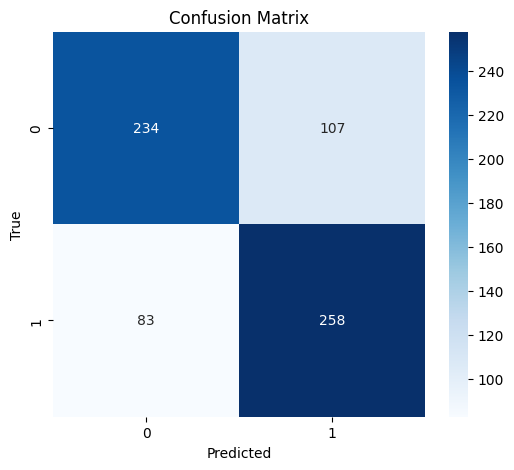

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# LR = 5e-3

Epoch 1: Loss = 36.2139, Train Acc = 0.5783, Dev Acc = 0.6446
Epoch 2: Loss = 19.9855, Train Acc = 0.8268, Dev Acc = 0.7059
Epoch 3: Loss = 7.4948, Train Acc = 0.9406, Dev Acc = 0.7598
Epoch 4: Loss = 4.4779, Train Acc = 0.9712, Dev Acc = 0.7451
Epoch 5: Loss = 2.4098, Train Acc = 0.9853, Dev Acc = 0.7230
Epoch 6: Loss = 2.3197, Train Acc = 0.9810, Dev Acc = 0.7574
Epoch 7: Loss = 0.9112, Train Acc = 0.9951, Dev Acc = 0.7574
Epoch 8: Loss = 1.7618, Train Acc = 0.9841, Dev Acc = 0.6961
Epoch 9: Loss = 2.4662, Train Acc = 0.9841, Dev Acc = 0.7623
Epoch 10: Loss = 1.1967, Train Acc = 0.9933, Dev Acc = 0.7475
Epoch 11: Loss = 0.3247, Train Acc = 0.9988, Dev Acc = 0.7426
Epoch 12: Loss = 0.0894, Train Acc = 1.0000, Dev Acc = 0.7304
Epoch 13: Loss = 0.0438, Train Acc = 1.0000, Dev Acc = 0.7500
Epoch 14: Loss = 0.0142, Train Acc = 1.0000, Dev Acc = 0.7451
Epoch 15: Loss = 0.0140, Train Acc = 1.0000, Dev Acc = 0.7574
Epoch 16: Loss = 0.0097, Train Acc = 1.0000, Dev Acc = 0.7549
Epoch 17: Loss 

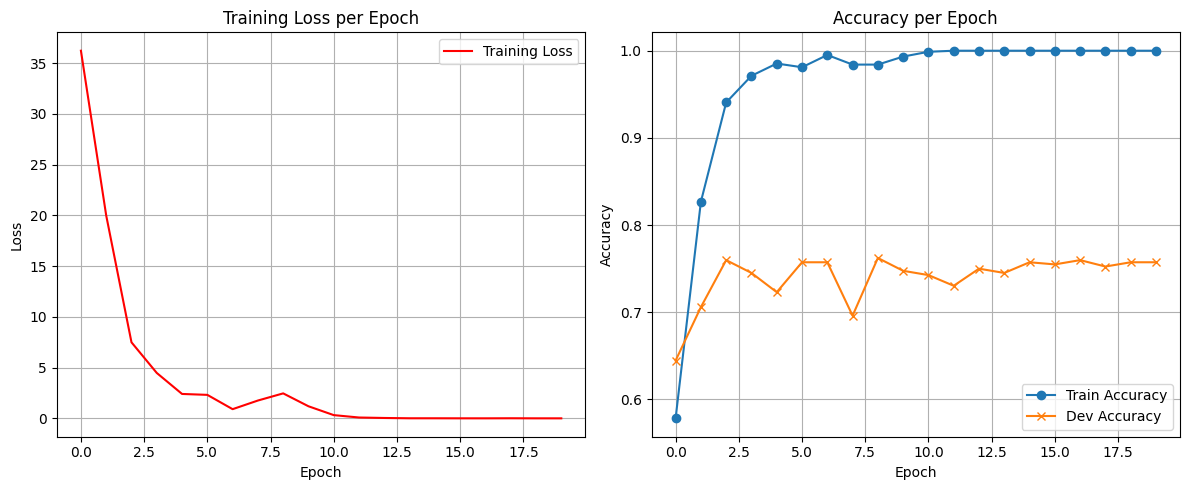


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7293    0.8186    0.7714       204
           1     0.7933    0.6961    0.7415       204

    accuracy                         0.7574       408
   macro avg     0.7613    0.7574    0.7564       408
weighted avg     0.7613    0.7574    0.7564       408

Confusion Matrix:
 [[167  37]
 [ 62 142]]


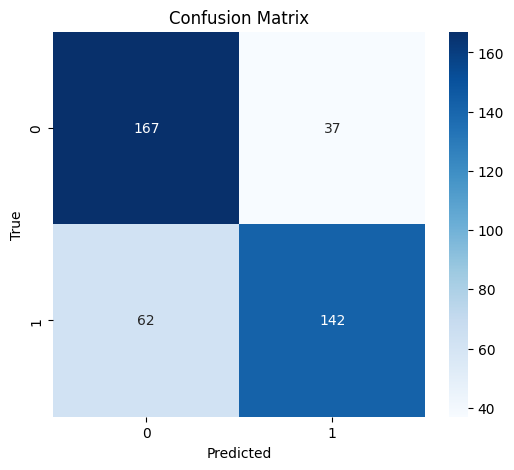


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6608    0.7771    0.7143       341
           1     0.7295    0.6012    0.6592       341

    accuracy                         0.6891       682
   macro avg     0.6952    0.6891    0.6867       682
weighted avg     0.6952    0.6891    0.6867       682

Confusion Matrix:
 [[265  76]
 [136 205]]


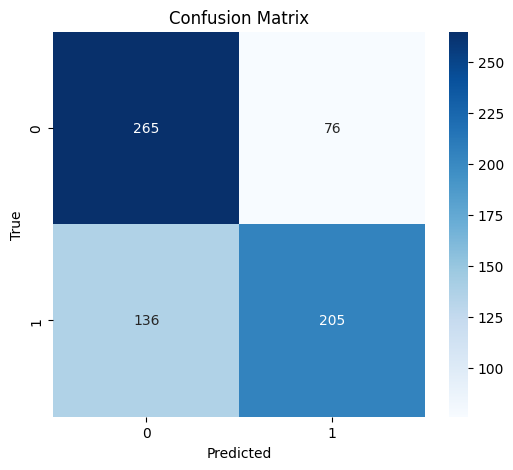

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-3
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Drop = 0.2

Epoch 1: Loss = 35.8290, Train Acc = 0.5453, Dev Acc = 0.5858
Epoch 2: Loss = 31.4324, Train Acc = 0.6628, Dev Acc = 0.7181
Epoch 3: Loss = 26.5750, Train Acc = 0.7595, Dev Acc = 0.7598
Epoch 4: Loss = 20.3162, Train Acc = 0.8201, Dev Acc = 0.6912
Epoch 5: Loss = 15.6933, Train Acc = 0.8703, Dev Acc = 0.7574
Epoch 6: Loss = 10.2519, Train Acc = 0.9296, Dev Acc = 0.7500
Epoch 7: Loss = 6.6761, Train Acc = 0.9602, Dev Acc = 0.7549
Epoch 8: Loss = 4.1224, Train Acc = 0.9749, Dev Acc = 0.7426
Epoch 9: Loss = 2.0605, Train Acc = 0.9896, Dev Acc = 0.7230
Epoch 10: Loss = 1.3457, Train Acc = 0.9951, Dev Acc = 0.7402
Epoch 11: Loss = 0.8159, Train Acc = 0.9976, Dev Acc = 0.7525
Epoch 12: Loss = 1.2664, Train Acc = 0.9927, Dev Acc = 0.6863
Epoch 13: Loss = 1.6965, Train Acc = 0.9878, Dev Acc = 0.7623
Epoch 14: Loss = 0.3740, Train Acc = 0.9982, Dev Acc = 0.7500
Epoch 15: Loss = 0.2086, Train Acc = 0.9994, Dev Acc = 0.7574
Epoch 16: Loss = 0.1249, Train Acc = 1.0000, Dev Acc = 0.7549
Epoch 17: L

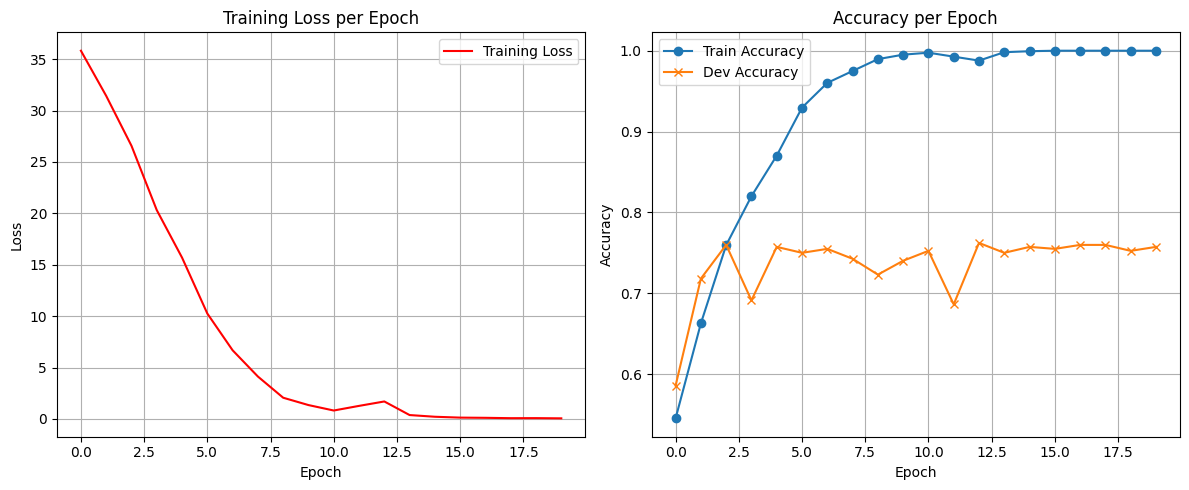


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.6966    0.9118    0.7898       204
           1     0.8723    0.6029    0.7130       204

    accuracy                         0.7574       408
   macro avg     0.7845    0.7574    0.7514       408
weighted avg     0.7845    0.7574    0.7514       408

Confusion Matrix:
 [[186  18]
 [ 81 123]]


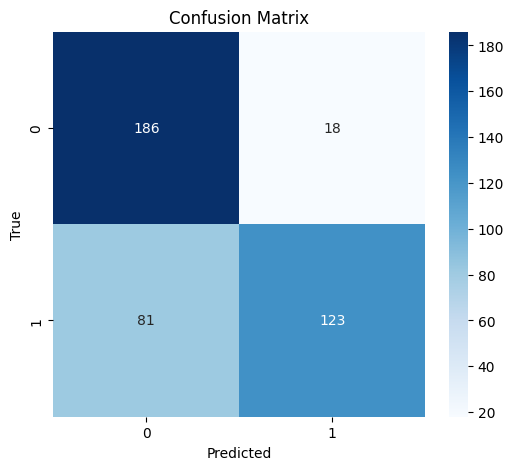


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.6725    0.9032    0.7710       341
           1     0.8527    0.5601    0.6761       341

    accuracy                         0.7317       682
   macro avg     0.7626    0.7317    0.7235       682
weighted avg     0.7626    0.7317    0.7235       682

Confusion Matrix:
 [[308  33]
 [150 191]]


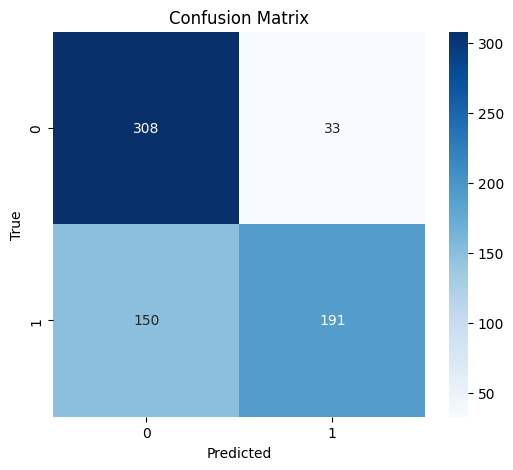

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 20
    dropout = 0.2
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Drop = 0.3

Epoch 1: Loss = 35.2488, Train Acc = 0.5679, Dev Acc = 0.6373
Epoch 2: Loss = 31.5125, Train Acc = 0.6530, Dev Acc = 0.7010
Epoch 3: Loss = 26.4172, Train Acc = 0.7503, Dev Acc = 0.7206
Epoch 4: Loss = 23.4992, Train Acc = 0.7889, Dev Acc = 0.7623
Epoch 5: Loss = 17.9842, Train Acc = 0.8494, Dev Acc = 0.7647
Epoch 6: Loss = 12.7997, Train Acc = 0.9009, Dev Acc = 0.7500
Epoch 7: Loss = 8.2343, Train Acc = 0.9461, Dev Acc = 0.7451
Epoch 8: Loss = 6.3782, Train Acc = 0.9535, Dev Acc = 0.7721
Epoch 9: Loss = 3.8156, Train Acc = 0.9774, Dev Acc = 0.7843
Epoch 10: Loss = 1.8437, Train Acc = 0.9884, Dev Acc = 0.7721
Epoch 11: Loss = 1.1255, Train Acc = 0.9945, Dev Acc = 0.7917
Epoch 12: Loss = 0.5850, Train Acc = 0.9988, Dev Acc = 0.7745
Epoch 13: Loss = 0.3825, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 14: Loss = 0.9792, Train Acc = 0.9939, Dev Acc = 0.7794
Epoch 15: Loss = 0.5803, Train Acc = 0.9988, Dev Acc = 0.7819
Epoch 16: Loss = 0.1814, Train Acc = 1.0000, Dev Acc = 0.7868
Epoch 17: L

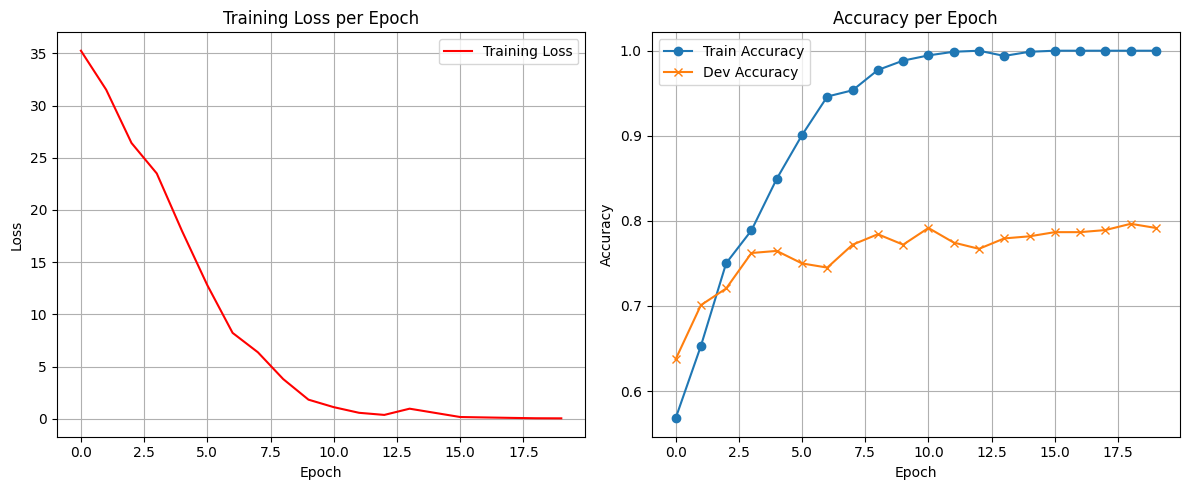


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7576    0.8578    0.8046       204
           1     0.8362    0.7255    0.7769       204

    accuracy                         0.7917       408
   macro avg     0.7969    0.7917    0.7908       408
weighted avg     0.7969    0.7917    0.7908       408

Confusion Matrix:
 [[175  29]
 [ 56 148]]


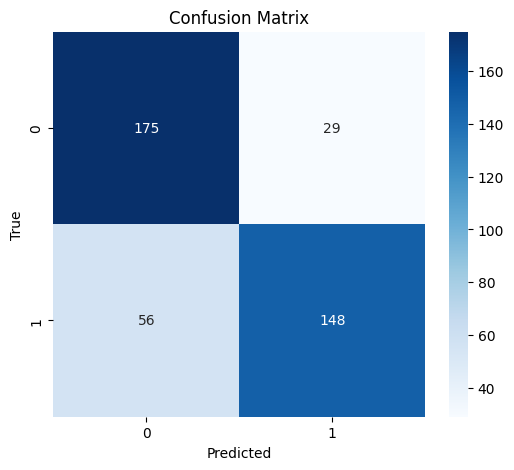


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7366    0.8446    0.7869       341
           1     0.8179    0.6979    0.7532       341

    accuracy                         0.7713       682
   macro avg     0.7772    0.7713    0.7700       682
weighted avg     0.7772    0.7713    0.7700       682

Confusion Matrix:
 [[288  53]
 [103 238]]


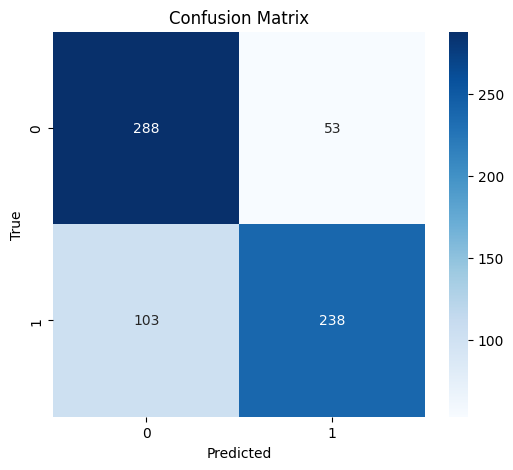

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 20
    dropout = 0.3
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# Drop = 0.5

Epoch 1: Loss = 36.7618, Train Acc = 0.5073, Dev Acc = 0.5980
Epoch 2: Loss = 33.8253, Train Acc = 0.6114, Dev Acc = 0.6789
Epoch 3: Loss = 29.0749, Train Acc = 0.7173, Dev Acc = 0.7500
Epoch 4: Loss = 25.9035, Train Acc = 0.7711, Dev Acc = 0.7500
Epoch 5: Loss = 21.5351, Train Acc = 0.8195, Dev Acc = 0.7623
Epoch 6: Loss = 18.4277, Train Acc = 0.8470, Dev Acc = 0.7647
Epoch 7: Loss = 13.3472, Train Acc = 0.9039, Dev Acc = 0.7745
Epoch 8: Loss = 10.6876, Train Acc = 0.9186, Dev Acc = 0.7500
Epoch 9: Loss = 7.4673, Train Acc = 0.9480, Dev Acc = 0.7843
Epoch 10: Loss = 4.9264, Train Acc = 0.9725, Dev Acc = 0.8064
Epoch 11: Loss = 3.8715, Train Acc = 0.9774, Dev Acc = 0.8039
Epoch 12: Loss = 2.9370, Train Acc = 0.9816, Dev Acc = 0.7917
Epoch 13: Loss = 1.7891, Train Acc = 0.9914, Dev Acc = 0.7966
Epoch 14: Loss = 1.4910, Train Acc = 0.9914, Dev Acc = 0.7917
Epoch 15: Loss = 0.8802, Train Acc = 0.9951, Dev Acc = 0.8015
Epoch 16: Loss = 0.8275, Train Acc = 0.9951, Dev Acc = 0.7966
Epoch 17:

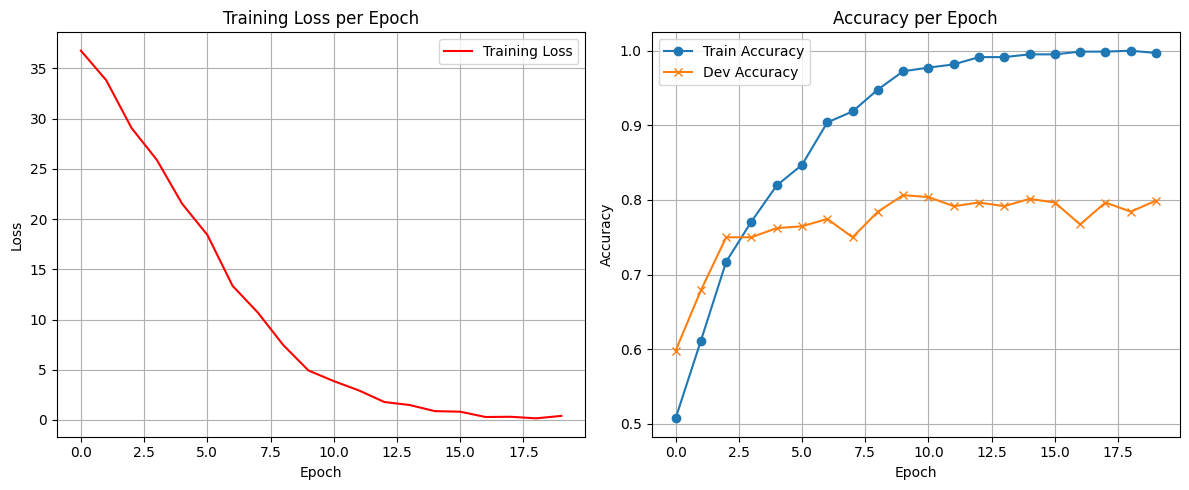


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.7500    0.8971    0.8170       204
           1     0.8720    0.7010    0.7772       204

    accuracy                         0.7990       408
   macro avg     0.8110    0.7990    0.7971       408
weighted avg     0.8110    0.7990    0.7971       408

Confusion Matrix:
 [[183  21]
 [ 61 143]]


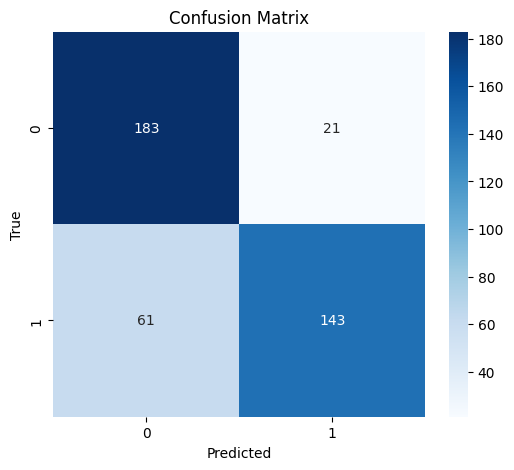


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7057    0.8651    0.7773       341
           1     0.8258    0.6393    0.7207       341

    accuracy                         0.7522       682
   macro avg     0.7657    0.7522    0.7490       682
weighted avg     0.7657    0.7522    0.7490       682

Confusion Matrix:
 [[295  46]
 [123 218]]


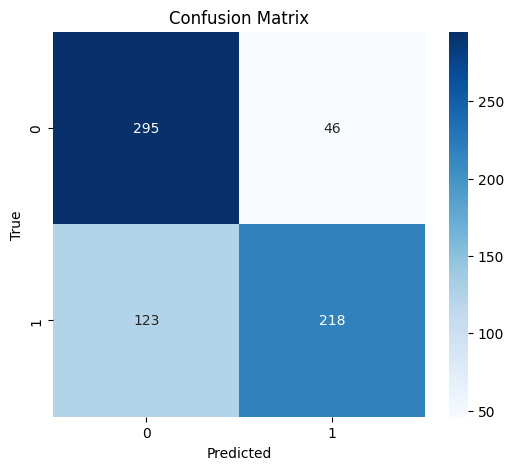

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 20
    dropout = 0.5
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)

def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []
    best_dev_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
            torch.save(model.state_dict(), "best_model.pt")

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Visualization
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 20
    dropout = 0.5
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n📈 Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n📈 Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()
